# Image Categorization

Data set from:
[ http://www.cs.utoronto.ca/%7Ekriz/cifar.html ], 
Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

Tutorial from  [ https://medium.com/towards-artificial-intelligence/image-classification-using-deep-learning-pytorch-a-case-study-with-flower-image-data-80a18554df63 ]

In [1]:
import os
import time
import numpy as np

import matplotlib.pyplot as mp
import matplotlib.image as mpimg

import tarfile, pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_printoptions(linewidth = 270)
torch.set_printoptions(threshold=10000)

## 0. Helper Methods

In [2]:
def unpickle(file):   
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def make_img_subset(dat, lab=None) :
    
    fig = mp.figure(figsize=(10,10))
    
    for i in range(1, 5 * 5 + 1) : 
        
        record = np.random.randint(len(dat))
        img = dat[record]
        
        ax = fig.add_subplot(5,5, i)

        ax.axis('off')
        fig.tight_layout()
              
        if lab is not None :
            ax.set_title('img[' + str(record) + '] cat:' + str(lab[record].item()))

        mp.imshow(img)
    

def img_tensor_chan(out, batten) : 
    out = out.detach().numpy()
    batten = batten.detach().transpose(1,2).transpose(2,3)
    fig = mp.figure(figsize=(40, 10))
    k = 1
    oidx = 0
    for i in out : 
        
        ax = fig.add_subplot(out.shape[0], out.shape[1] + 1, k)
        mp.imshow(batten[oidx])
        k += 1
        for j in i :
            ax = fig.add_subplot(out.shape[0], out.shape[1] + 1, k)
            ax.set_title('img:' + str(k-1))
#             ax.axis('off')
            fig.tight_layout()
            mp.imshow(j)
            k += 1
        oidx += 1

## 1. Get

Download files into current directory.

In [3]:
# extract
tar = tarfile.open("cifar-10-python.tar.gz")
tar.extractall('.')
tar.close()
print("files extracted.")

files extracted.


### 1.1. Data usage example

In [4]:
# unpickle for use
example_set = unpickle(os.path.join("./cifar-10-batches-py/data_batch_1"))

# get labels
example_train_lables = torch.tensor(example_set[b'labels'])
print('example labels (unique):', example_train_lables.unique())

# get img data
example_data = torch.tensor(example_set[b'data'])
print('example data shape:', example_data.shape)

#scale 255 ints to (0,1) floats
example_train_data = example_data.float() / 255.

# reshape to 3x32x32
example_train_data = example_train_data.reshape((10000, 3, 32, 32))
print('example tensor shape', example_train_data.shape)

example labels (unique): tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
example data shape: torch.Size([10000, 3072])
example tensor shape torch.Size([10000, 3, 32, 32])


### 1.2. Verify
to verify that the data was unpacked and folded correctly, transpose the example_train_data so that the three RGB channels are indexed last then plot a rand sampling of the image data

bat pixels torch.Size([10000, 32, 32, 3])


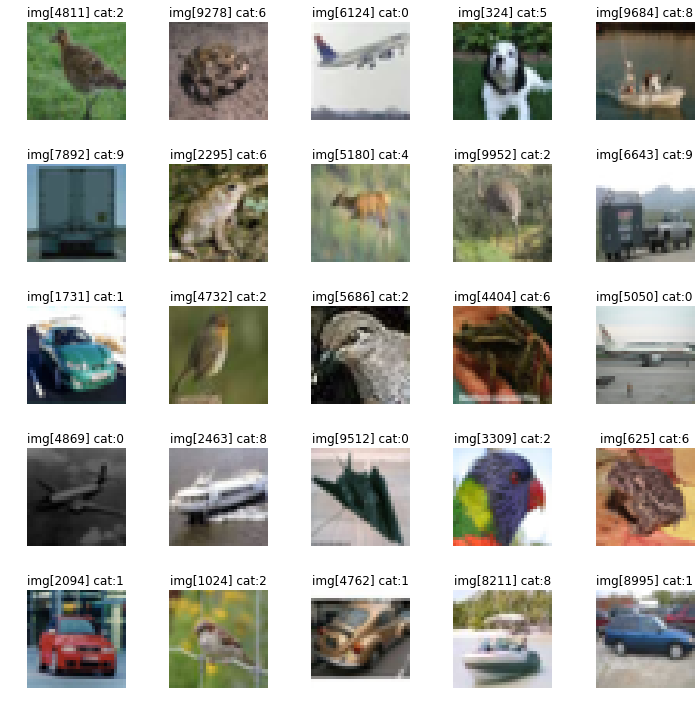

In [5]:
example_pixels = example_train_data.transpose(1,2).transpose(2,3)

print('bat pixels', example_pixels.shape)   
make_img_subset(example_pixels, example_train_lables)

### 1.3. Lookup 👓 

lookup image: 7233 b'passenger_ship_s_002159.png' 8


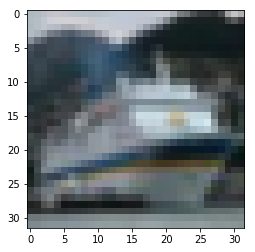

In [6]:
#image number to investigate
lookup = 7233
print('lookup image:', str(lookup) , example_set[b'filenames'][lookup], example_set[b'labels'][lookup] )
mp.imshow(example_pixels[lookup])

## 2. Neural Network Model

( Conv-Rel-MPool-Conv-Rel-Lin )

Here, the sequential convolutions are used with ReLU activations and max pool layer to reduce the mapping size.
The sequence output is then flattened and sent to a full connected linear layer to categorize.

This approach is simplistic and with little training, has adequate accuracy.

In [7]:
class imgcat(nn.Module) :
    def __init__(self) :
        super(imgcat, self).__init__()
        
        self.con = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.rel = nn.ReLU()      
        
        self.mpool = nn.MaxPool2d(kernel_size=2)
        
        self.con2 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.rel2 = nn.ReLU()
        
        self.lin = nn.Linear(in_features=20 * 16 * 16, out_features=10)

        #verify
        print('created nerual net:\n', self)
        print('---')
    
    def forward(self, dat, verbose=False) :
        
        if verbose : print('in', dat.shape)
        
        out = self.con(dat)
        out = self.rel(out)
        
        if verbose : print('con,rel', out.shape, '--see images below.'); img_tensor_chan(out[0:1], dat[0:1]);
        
        out = self.mpool(out)
        
        if verbose : print('mpol', out.shape, '--see images below.'); img_tensor_chan(out[0:1], dat[0:1]);
        
        out = self.con2(out)
        out = self.rel2(out)
       
        if verbose : print('con2,rel2', out.shape, '--see images below.'); img_tensor_chan(out[0:1], dat[0:1]);
        
        out = out.flatten(1) # OR use out = out.view(-1, 10 * 16 * 16)
        
        out = self.lin(out)
        
        if verbose : print('lin-out', out.shape)
        
        return out

## 2.1. Usage Example

An instance of the Image Categorization neural network is defined.
The displayed description was specified to be called at initialization.
The model (only) is saved, for usage later (if necessary).

A slice of the training data is used to illustrate the result of some of the layers of the neural network.
It can be seen in the first row of images that the first convolution yielded 16 channels, activated by a ReLU function.
The max pool layer reduces the feature map from 32x32 to 16x16 (row 2).
The second/last convolution yields 20 channels, with a ReLU activation.
The output is the result of a fully connected linear layer where the number of input channels is the length of the flattened channels (shape\[1,20x26x26\]) and the number of out channels is the number of categories.


In [8]:
# make nn instance
example_nnic = imgcat()

#save
torch.save(example_nnic, 'img_cat.pth')

created nerual net:
 imgcat(
  (con): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rel): ReLU()
  (mpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con2): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rel2): ReLU()
  (lin): Linear(in_features=5120, out_features=10, bias=True)
)
---


C:\Users\Jaret\Miniconda3\envs\envPyTorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type imgcat. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


The network can be visualize with netron package.
The netron project is found at [ https://github.com/lutzroeder/Netron ].

In [9]:
# import netron; 

# netron.start('img_cat.pth')

in torch.Size([100, 3, 32, 32])
con,rel torch.Size([100, 16, 32, 32]) --see images below.
mpol torch.Size([100, 16, 16, 16]) --see images below.
con2,rel2 torch.Size([100, 20, 16, 16]) --see images below.
lin-out torch.Size([100, 10])


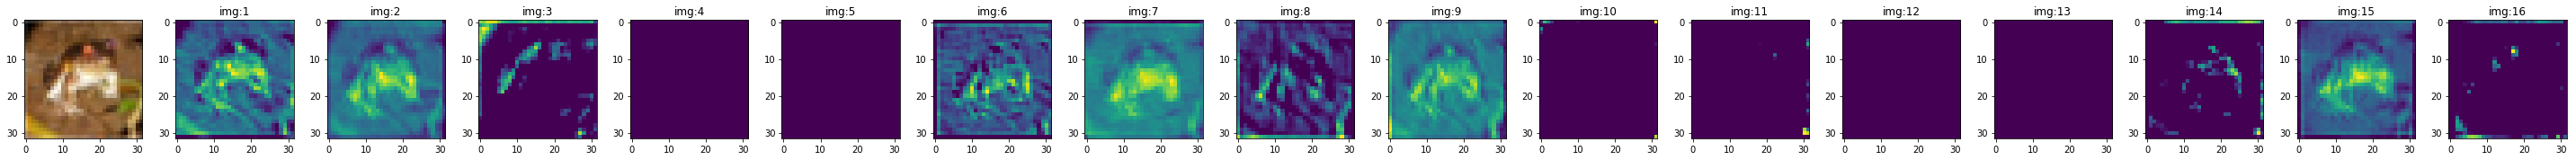

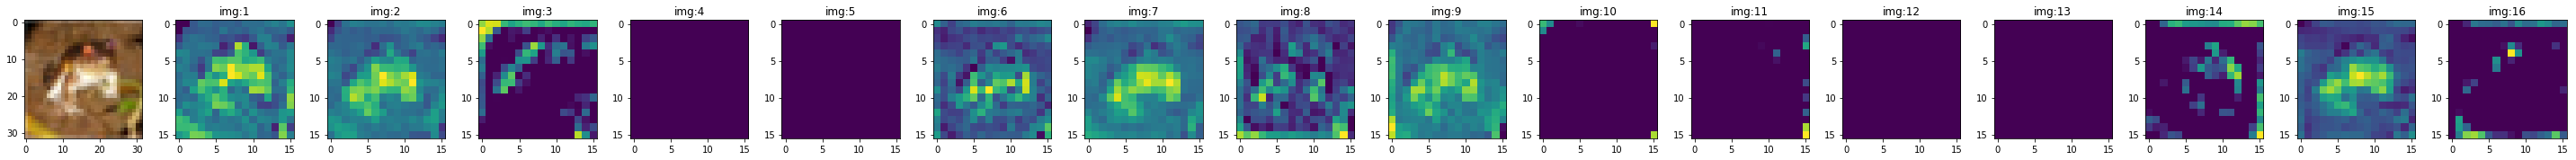

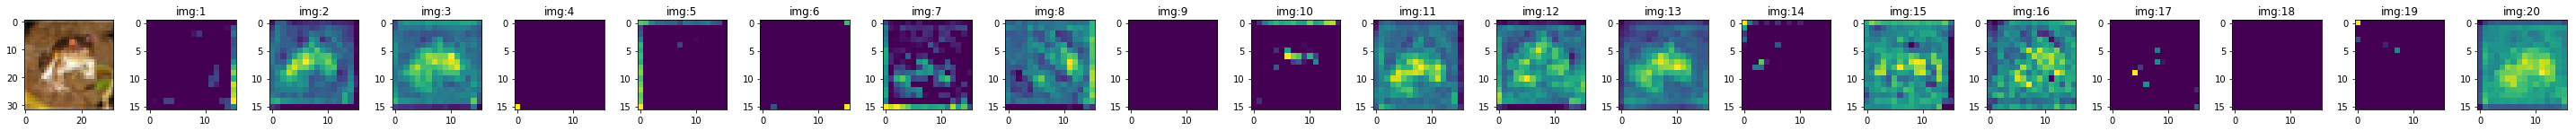

In [10]:
# send example data (from above) through network
example_out = example_nnic(example_train_data[0:100], True)

In [11]:
print('example out:', example_out[0])
print('example prediction:', example_out[0].argmax().item() )
print('example label:', example_train_lables[0].item())

example out: tensor([ 0.0090,  0.0463, -0.0023, -0.0682,  0.0313, -0.0039, -0.0219,  0.0628,  0.0809, -0.0751], grad_fn=<SelectBackward>)
example prediction: 8
example label: 6


## 3. Training / Optimizer Method

This method will train the model for the specified number of epochs, dividing the batch file into smaller batches.

Note: Splitting the 10,000 image batch helps with memory management.
It may not be necessary for your computer.
To reduce the memory usage per iteration, increase the number the value of `no_subbat`.

This method requires an optimizer and loss function to be defined.

It assumes that the `./cifar-10-batches-py/data_batch_#` files are used.

In [12]:
def train(model, optimizer, loss_fn, epochs, no_subbat = 10, verbose=False) :

    print('epochs:', epochs, 'number of sub batches:', no_subbat, '\n')
    
#     optimizer = torch.optim.Adam(catogorizer.parameters())

#     loss_fn = nn.CrossEntropyLoss()

    start_time = time.time()

    for e in range(epochs) :

        print('epoch:', e + 1, end=' ')

        batno = 0

        for f in [f for f in os.listdir("./cifar-10-batches-py/") if 'data_batch' in f] :

            # get training data
            datset = unpickle(os.path.join("./cifar-10-batches-py",f))
            batlab = torch.tensor(datset[b'labels'])
            batten = torch.tensor(datset[b'data']).float() / 255.
            batten = batten.reshape((10000, 3, 32, 32))

            batno += 1
            subbat_n = 0
            subbat_size = np.floor_divide(len(batten), no_subbat)

            if verbose : print('\nbatch file number:', batno , end=' ')

            for b in range(no_subbat) :

                # forward pass
                out = model.forward(batten[subbat_n * subbat_size : (subbat_n + 1) * subbat_size + subbat_size], False)

                # calculate loss
                loss = loss_fn(out, batlab[subbat_n * subbat_size : (subbat_n + 1) * subbat_size + subbat_size])

                # reset optimizer gradient
                optimizer.zero_grad()

                # backward pass
                loss.backward()

                # increment optimizer
                optimizer.step() 

                # feedback
                if verbose : print(np.round(loss.item(),2), end=', ') 
                else : print('.', end='')
                subbat_n += 1

        # feedback
        print('::> loss:', np.round(loss.item(),2), 'h:', np.round((time.time() - start_time) / 3600), 4)

        batno += 1
        
    # feedback
    run_time = (time.time() - start_time) / 3600
    print('run time (h):', run_time, '\n')

def save_model(model, optimizer, filename='mod') :
    
    # save model
    torch.save(model, filename + '_model.pt')
    print('model saved.')

    # save to resume training later
    state = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
    torch.save(state, filename + '_train.pt')
    print('training state saved.')

    # save state for inference
    torch.save(model.state_dict(), filename + '_state.pt')
    print('prediction model saved.')

In [13]:
# # instance imgcat
# catogorizer = imgcat()

# # define optimizer
# optimizer = torch.optim.Adam(catogorizer.parameters())

# # define loss function
# loss_fn = nn.CrossEntropyLoss()

# # set number of epochs
# epochs = 2

# # define a smaller sized sub-batches of the batch file
# no_subbat = 10

# #feedback
# print('epochs:', epochs)
# print('number of sub batches:', no_subbat, '\n')
# verbose = True
# start_time = time.time()

# # training loop
# for e in range(epochs) :
    
#     print('epoch:', e + 1, end=' ')
    
#     batno = 0
    
#     for f in [f for f in os.listdir("./cifar-10-batches-py/") if 'data_batch' in f] :

#         # get training data batch file
#         datset = unpickle(os.path.join("./cifar-10-batches-py",f))
#         batlab = torch.tensor(datset[b'labels'])
#         batten = torch.tensor(datset[b'data']).float() / 255.
#         batten = batten.reshape((10000, 3, 32, 32))

#         # define parameters for sub-batches
#         batno += 1
#         subbat_n = 0
#         subbat_size = np.floor_divide(len(batten), no_subbat)
        
#         if verbose : print('\nbatch number:', batno , end=' :: ')

#         for b in range(no_subbat) :

#             # forward pass
#             out = catogorizer.forward(batten[subbat_n * subbat_size : (subbat_n + 1) * subbat_size + subbat_size], False)

#             # calculate loss
#             loss = loss_fn(out, batlab[subbat_n * subbat_size : (subbat_n + 1) * subbat_size + subbat_size])

#             # reset optimizer gradient
#             optimizer.zero_grad()

#             # backward pass
#             loss.backward()

#             # increment optimizer
#             optimizer.step() 
            
#             # feedback
#             if verbose : print(np.round(loss.item(),2), end=', ') 
#             else : print('.', end='')
                
#             subbat_n += 1
                
#     # feedback
#     print('::> loss:', np.round(loss.item(),2), 'h:', np.round((time.time() - start_time) / 3600), 4)
    
#     batno += 1
        
# # feedback
# run_time = (time.time() - start_time) / 3600
# print('run time (h):', run_time, '\n')


# # save model
# torch.save(catogorizer, 'img_cat_model.pt')
# print('model saved.')

# # save to resume training later
# state = {'model_state_dict': catogorizer.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
# torch.save(state, 'img_cat_train.pt')
# print('training state saved.')

# # save state for inference
# torch.save(catogorizer.state_dict(), 'img_cat_state.pt')
# print('prediction model saved.')

#### 3.1 Start Training

Similar to what was shown before, instance, train and save the model.

A seperate method `save_model` was defined to save the model , model state, and optimizer state.

In [14]:
nnic = imgcat()

optimizer = torch.optim.Adam(nnic.parameters())
loss_fn = nn.CrossEntropyLoss()

created nerual net:
 imgcat(
  (con): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rel): ReLU()
  (mpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con2): Conv2d(16, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rel2): ReLU()
  (lin): Linear(in_features=5120, out_features=10, bias=True)
)
---


In [15]:
train(nnic, optimizer, loss_fn, epochs=1, no_subbat=10, verbose=True)

save_model(nnic, optimizer, 'imgcat')

epochs: 1 number of sub batches: 10 

epoch: 1 
batch file number: 1 2.3, 2.29, 2.27, 2.26, 2.24, 2.23, 2.21, 2.18, 2.16, 2.14, 
batch file number: 2 2.13, 2.1, 2.07, 2.07, 2.06, 2.04, 2.03, 2.01, 2.0, 1.98, 
batch file number: 3 1.96, 1.95, 1.9, 1.9, 1.9, 1.91, 1.91, 1.92, 1.89, 1.88, 
batch file number: 4 1.91, 1.89, 1.87, 1.86, 1.83, 1.8, 1.83, 1.82, 1.81, 1.83, 
batch file number: 5 1.8, 1.78, 1.77, 1.75, 1.75, 1.74, 1.72, 1.74, 1.74, 1.69, ::> loss: 1.69 h: 0.0 4
run time (h): 0.039851888484425016 

model saved.
training state saved.
prediction model saved.


## 4. Test Method

This method selects a specified random sampling of images in the test data set, makes a prediction, and determines prediciton accuaracy.

In [16]:
def test_rand(model, notests):
    #switch nn to evaluation mode (not training)
    model.eval()

    # get data - unpickle
    testset = unpickle("cifar-10-batches-py/test_batch")
    testlab = torch.tensor(testset[b'labels'])
    testdat = torch.tensor(testset[b'data']).float() / 255.
    testdat = testdat.reshape((10000, 3, 32, 32))

    # get test sub-set image data and labels
    imgs = torch.randint(high=len(testdat), size=(notests,))
    test_mini = testdat[imgs]
    target_mini = testlab[imgs]

    # predict
    out = model(test_mini)

    # analysis and feedback
    pred = out.detach().argmax(dim=1)
    print('prediction:\n', pred, '\ntarget:\n', target_mini)

    acc = (pred - target_mini) == 0
    acc = acc.sum().float() / notests
    print('accuracy:', np.round(acc.item() * 100,2), '%')

In [17]:
test_rand(nnic, 100)

prediction:
 tensor([9, 9, 9, 8, 6, 2, 7, 8, 1, 6, 9, 9, 6, 8, 1, 8, 8, 3, 6, 1, 9, 0, 4, 6, 7, 1, 9, 6, 9, 9, 8, 1, 6, 6, 6, 1, 5, 9, 6, 9, 6, 5, 6, 7, 9, 9, 8, 9, 1, 3, 9, 9, 6, 0, 8, 3, 9, 2, 7, 3, 3, 1, 3, 6, 5, 3, 8, 7, 5, 9, 7, 6, 8, 9, 8, 6, 5, 3, 1, 6, 6, 0, 5, 3, 6, 5, 6,
        1, 9, 5, 0, 5, 9, 6, 3, 6, 6, 3, 8, 7]) 
target:
 tensor([9, 5, 9, 0, 4, 2, 6, 5, 9, 6, 9, 0, 5, 0, 1, 4, 3, 3, 4, 7, 1, 7, 0, 9, 7, 9, 1, 6, 1, 7, 8, 1, 4, 4, 3, 1, 4, 1, 3, 9, 6, 4, 4, 3, 9, 7, 0, 3, 8, 4, 4, 8, 8, 0, 0, 6, 8, 4, 6, 7, 2, 1, 3, 5, 5, 4, 0, 3, 5, 8, 5, 4, 0, 0, 8, 6, 5, 1, 1, 6, 6, 0, 3, 3, 6, 5, 4,
        1, 1, 5, 0, 0, 9, 6, 1, 6, 4, 3, 8, 7])
accuracy: 39.0 %


# 5. Restore

Assuming the model was trainined and the optimizer and model state were saved, the model can be restored to resume training.

[ https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch ]

In [18]:
restored_model = torch.load('imgcat_model.pt')

restored_optimizer = torch.optim.Adam(nnic.parameters())
restored_loss_fn = nn.CrossEntropyLoss()

mod_opt_state = torch.load('imgcat_train.pt')
restored_model.load_state_dict(mod_opt_state['model_state_dict'])
restored_optimizer.load_state_dict(mod_opt_state['optimizer_state_dict'])

In [19]:
# --- continue training
train(restored_model, restored_optimizer, restored_loss_fn, epochs=1, no_subbat=100, verbose=False)

epochs: 1 number of sub batches: 100 

epoch: 1 ....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................::> loss: 1.82 h: 0.0 4
run time (h): 0.04919559445646074 

